# Image classification
## Human Pose Classification

In [28]:
import torch
print("GPU available:", torch.cuda.is_available())
print("device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

GPU available: True
device name: NVIDIA GeForce GTX 1650


In [29]:
import warnings
warnings.filterwarnings('ignore')


In [30]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Human_Action_Recognition", split='train')

In [31]:
dataset = dataset.shuffle().train_test_split(test_size=0.2)

In [32]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x194>,
 'labels': 12}

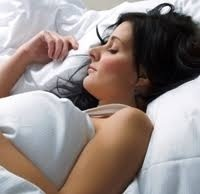

In [33]:
dataset['train'][0]['image']

In [34]:
labels = dataset['train'].features['labels'].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}
{0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}


## Image Preprocessing

In [35]:
from transformers import AutoImageProcessor #-> like Tokenizer

model_ckpt = "google/vit-base-patch16-224-in21k"
# model_ckpt = "microsoft/swinv2-tiny-patch4-window16-256"

In [36]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (image_processor.size['shortest_edge'] if 'shortest_edge' in image_processor.size 
        else (image_processor.size['height'], image_processor.size['width']))

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])
""
def transforms(batch):
    batch['pixel_values'] = [_transforms(img.convert('RGB')) for img in batch['image']]

    del batch['image']

    return batch

In [37]:
dataset = dataset.with_transform(transforms)

## Evaluate the model


In [38]:
# !pip install evaluate

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Vision Transformer (ViT) Fine Tuning for Image Classification

In [39]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch

In [40]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
len(labels)

15

## Model Training

In [48]:
from transformers import TrainingArguments, Trainer


args = TrainingArguments(
    output_dir="train_dir",
    remove_unused_columns=False,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    fp16=True  # Use mixed precision training
    
)


trainer = Trainer(
    model = model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

In [49]:
trainer.train()

  0%|          | 0/3150 [01:37<?, ?it/s]
                                                    
 16%|█▌        | 500/3150 [38:50<3:25:07,  4.64s/it]

{'loss': 2.019, 'grad_norm': 3.207561492919922, 'learning_rate': 1.6825396825396828e-05, 'epoch': 0.79}


 20%|██        | 630/3150 [48:57<3:15:24,  4.65s/it]































































































































































                                                    
                                     
 20%|██        | 630/3150 [53:05<3:15:24,  4.65s/it]


{'eval_loss': 1.316857933998108, 'eval_accuracy': 0.7408730158730159, 'eval_runtime': 247.7061, 'eval_samples_per_second': 10.173, 'eval_steps_per_second': 0.638, 'epoch': 1.0}


                                                       
 32%|███▏      | 1000/3150 [1:21:55<2:46:37,  4.65s/it]

{'loss': 1.2586, 'grad_norm': 3.636824607849121, 'learning_rate': 1.3657142857142858e-05, 'epoch': 1.59}


 40%|████      | 1260/3150 [1:42:10<2:27:16,  4.68s/it]





























































































































































                                                       
                                       

 40%|████      | 1260/3150 [1:46:18<2:27:16,  4.68s/it]



{'eval_loss': 1.0077152252197266, 'eval_accuracy': 0.7726190476190476, 'eval_runtime': 248.0205, 'eval_samples_per_second': 10.16, 'eval_steps_per_second': 0.637, 'epoch': 2.0}


                                                        
 48%|████▊     | 1500/3150 [2:05:02<2:09:07,  4.70s/it]

{'loss': 1.0085, 'grad_norm': 8.294342994689941, 'learning_rate': 1.0482539682539683e-05, 'epoch': 2.38}


 60%|██████    | 1890/3150 [2:35:25<1:37:54,  4.66s/it]





























































































































































                                                       
                                       

 60%|██████    | 1890/3150 [2:39:33<1:37:54,  4.66s/it]



{'eval_loss': 0.9426705241203308, 'eval_accuracy': 0.7599206349206349, 'eval_runtime': 247.9113, 'eval_samples_per_second': 10.165, 'eval_steps_per_second': 0.637, 'epoch': 3.0}


                                                        
 63%|██████▎   | 2000/3150 [2:48:08<1:29:34,  4.67s/it]

{'loss': 0.8861, 'grad_norm': 7.352535724639893, 'learning_rate': 7.307936507936508e-06, 'epoch': 3.17}


                                                       
 79%|███████▉  | 2500/3150 [3:27:05<50:30,  4.66s/it]

{'loss': 0.8292, 'grad_norm': 4.55532693862915, 'learning_rate': 4.133333333333333e-06, 'epoch': 3.97}


 80%|████████  | 2520/3150 [3:28:39<48:51,  4.65s/it]





























































































































































                                                     
                                       

 80%|████████  | 2520/3150 [3:32:47<48:51,  4.65s/it]



{'eval_loss': 0.8718247413635254, 'eval_accuracy': 0.775, 'eval_runtime': 248.011, 'eval_samples_per_second': 10.161, 'eval_steps_per_second': 0.637, 'epoch': 4.0}


                                                        
 95%|█████████▌| 3000/3150 [4:10:11<11:43,  4.69s/it]

{'loss': 0.7556, 'grad_norm': 8.690861701965332, 'learning_rate': 9.587301587301589e-07, 'epoch': 4.76}


100%|██████████| 3150/3150 [4:21:52<00:00,  4.70s/it]





























































































































































                                                     
                                       

100%|██████████| 3150/3150 [4:26:02<00:00,  4.70s/it]



{'eval_loss': 0.8629398345947266, 'eval_accuracy': 0.7757936507936508, 'eval_runtime': 247.919, 'eval_samples_per_second': 10.165, 'eval_steps_per_second': 0.637, 'epoch': 5.0}


                                                     
100%|██████████| 3150/3150 [4:26:04<00:00,  5.07s/it]

{'train_runtime': 15964.2729, 'train_samples_per_second': 3.157, 'train_steps_per_second': 0.197, 'train_loss': 1.1093273635137648, 'epoch': 5.0}


TrainOutput(global_step=3150, training_loss=1.1093273635137648, metrics={'train_runtime': 15964.2729, 'train_samples_per_second': 3.157, 'train_steps_per_second': 0.197, 'total_flos': 3.906051336688435e+18, 'train_loss': 1.1093273635137648, 'epoch': 5.0})

In [50]:
trainer.evaluate()

100%|██████████| 158/158 [03:51<00:00,  1.47s/it]


{'eval_loss': 0.8290647268295288,
 'eval_accuracy': 0.7861111111111111,
 'eval_runtime': 234.0491,
 'eval_samples_per_second': 10.767,
 'eval_steps_per_second': 0.675,
 'epoch': 5.0}

In [51]:
trainer.save_model('vit-human-pose-classification')

## Classification Report and Confusion Matrix

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
logits = trainer.predict(dataset['test'])

100%|██████████| 158/158 [03:52<00:00,  1.47s/it]


In [54]:
logits = logits.predictions

In [55]:
y_pred = np.argmax(logits, axis=1)

In [56]:
y_true = [x['labels'] for x in dataset['test']]

In [57]:
print(classification_report(y_true, y_pred, target_names=labels))

                    precision    recall  f1-score   support

           calling       0.67      0.65      0.66       173
          clapping       0.77      0.77      0.77       164
           cycling       0.91      0.93      0.92       175
           dancing       0.88      0.84      0.86       171
          drinking       0.85      0.78      0.81       154
            eating       0.86      0.87      0.87       182
          fighting       0.79      0.87      0.83       175
           hugging       0.78      0.80      0.79       165
          laughing       0.78      0.76      0.77       161
listening_to_music       0.70      0.66      0.68       156
           running       0.83      0.85      0.84       172
           sitting       0.64      0.71      0.67       156
          sleeping       0.81      0.86      0.83       170
           texting       0.67      0.63      0.65       177
      using_laptop       0.75      0.69      0.72       169

          accuracy                    

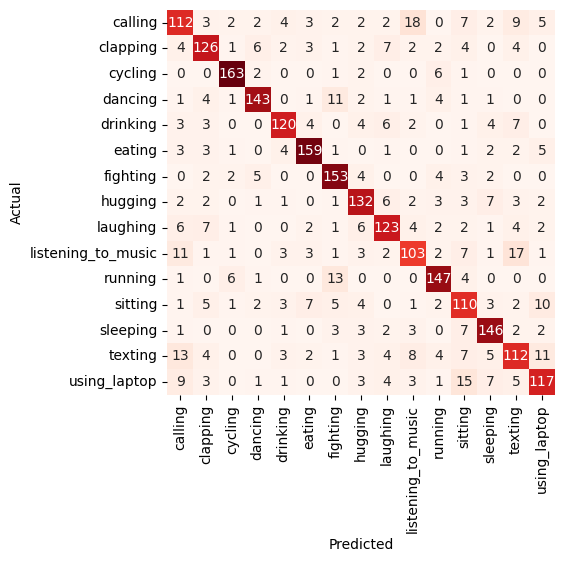

In [58]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Prediction on Real Image

In [59]:
from transformers import pipeline
from transformers import AutoImageProcessor

model_ckpt = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)

pipe = pipeline('image-classification', model='vit-human-pose-classification', 
                image_processor=image_processor)

url = "https://images.pexels.com/photos/1755385/pexels-photo-1755385.jpeg"

output = pipe(url)
output

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'sitting', 'score': 0.940518856048584},
 {'label': 'using_laptop', 'score': 0.6163833737373352},
 {'label': 'texting', 'score': 0.5748733878135681},
 {'label': 'listening_to_music', 'score': 0.5125025510787964},
 {'label': 'sleeping', 'score': 0.49042293429374695}]

In [60]:
image_processor.save_pretrained('vit-human-pose-classification')

['vit-human-pose-classification\\preprocessor_config.json']

In [61]:
# Load the model and image processor from the local directory
from transformers import AutoImageProcessor, AutoModel

local_directory = 'vit-human-pose-classification'
image_processor = AutoImageProcessor.from_pretrained(local_directory, use_fast=True)
model = AutoModel.from_pretrained(local_directory, local_files_only=True)

Some weights of ViTModel were not initialized from the model checkpoint at vit-human-pose-classification and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Push Model to AWS S3

In [62]:
# upload model folder to s3 bucket ml-models/vit-human-pose-classification
import os
import boto3

s3 = boto3.client('s3')
bucket_name = 'mlops-sentianni'

def upload_directory(directory_path, s3_prefix):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file).replace("\\", "/")
            relpath = os.path.relpath(file_path, directory_path)
            s3_key = os.path.join(s3_prefix, relpath).replace("\\", "/")
            
            s3.upload_file(file_path, bucket_name, s3_key)


upload_directory('vit-human-pose-classification', 'ml-models/vit-human-pose-classification')